In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

import milopy.core as milo
import milopy.plot as milopl

In [3]:
input_file="./ctcl/data/atlas_subset-tcells_benign.h5ad"
adata = sc.read_h5ad(input_file)

In [4]:
adata

AnnData object with n_obs × n_vars = 229915 × 15777
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type', 'site', 'tissue', 'Sex', 'type'
    var: 'genes', 'gene_ids'
    uns: 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'site_colors', 'tech_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs['cell_type'].value_counts()

Th              91663
Tc              62075
Treg            41698
Tc_IL13_IL22    10974
Tc17_Th17        8154
ILC1_3           6556
NK               4257
ILC1_NK          3693
ILC2              845
Name: cell_type, dtype: int64

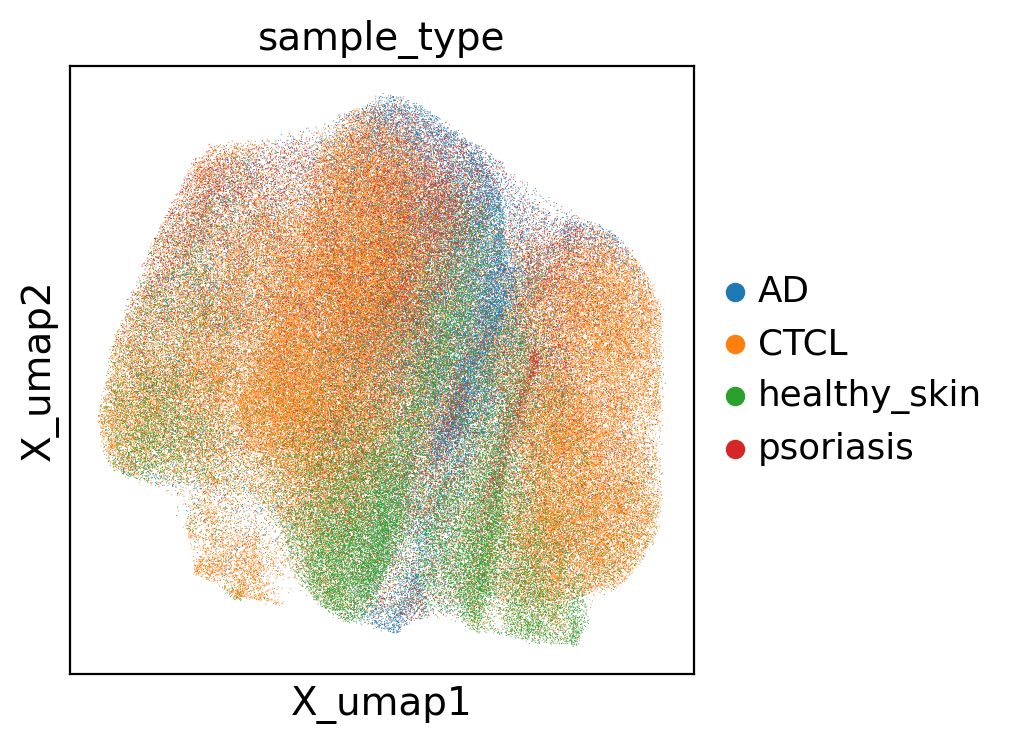

In [35]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.embedding(adata, color=['sample_type'], basis = 'X_umap')

In [10]:
adata.obs['sample_type'].value_counts()

CTCL            130175
healthy_skin     44923
AD               30725
psoriasis        24092
Name: sample_type, dtype: int64

In [11]:
adata.obs['Condition'] = "a_Other"
ll = adata.obs['sample_type'] == 'CTCL'
adata.obs.loc[ll, 'Condition'] = 'CTCL'

In [12]:
adata.obs['Condition'].value_counts()

CTCL       130175
a_Other     99740
Name: Condition, dtype: int64

In [13]:
adata

AnnData object with n_obs × n_vars = 229915 × 15777
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type', 'site', 'tissue', 'Sex', 'type', 'Condition'
    var: 'genes', 'gene_ids'
    uns: 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'site_colors', 'tech_colors', 'tissue_colors', 'type_colors', 'umap'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [14]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

computing neighbors


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['scvi']`
    `.obsp['scvi_distances']`, distances for each pair of neighbors
    `.obsp['scvi_connectivities']`, weighted adjacency matrix (0:02:48)


In [15]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
GAACCTAGTCTCCACT-1_CTCL1_CTCL1_CTCL1,1,0.545982
GACCAATGTTTCGCTC-1_CTCL1_CTCL1_CTCL1,1,0.403498
GTCCTCAGTTCAGCGC-1_CTCL1_CTCL1_CTCL1,1,0.474964
GTGTTAGAGGGCTCTC-1_CTCL1_CTCL1_CTCL1,1,0.425952
GTGTTAGTCCACTCCA-1_CTCL1_CTCL1_CTCL1,1,0.424060
...,...,...
CTCGTACTCAACGAAA-92_S5,1,0.347638
CGCTGGAAGATGTGGC-92_S5,1,0.337109
GACGTGCAGGTCGGAT-92_S5,1,0.317128
TCATTACTCCTTGACC-92_S5,1,0.506671


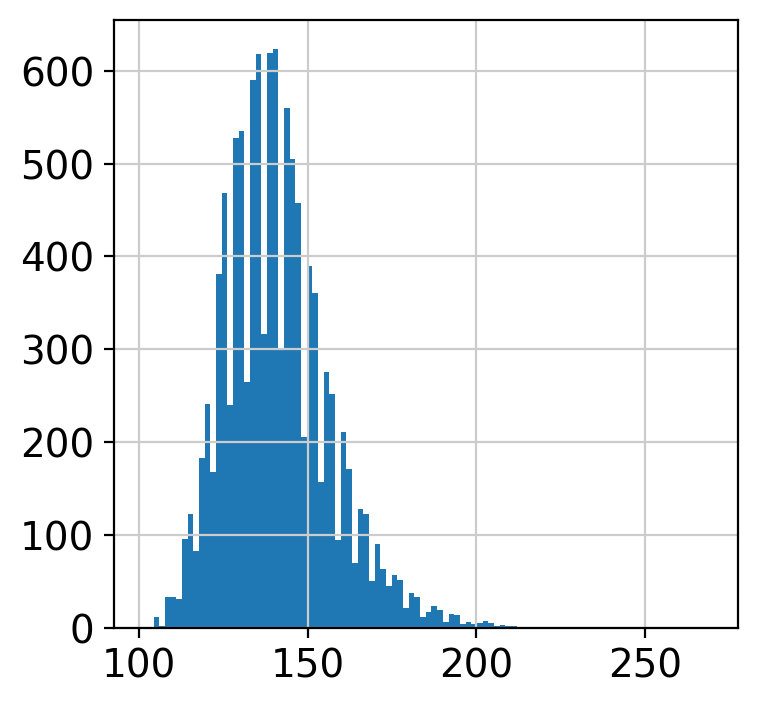

In [16]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [17]:
milo.count_nhoods(adata, sample_col="donor")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/milopy/core.py:157: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  nhood_adata = anndata.AnnData(X=nhood_count_mat, var=nhood_var)


In [18]:
milo.DA_nhoods(adata, design="~Condition")

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:2085: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)


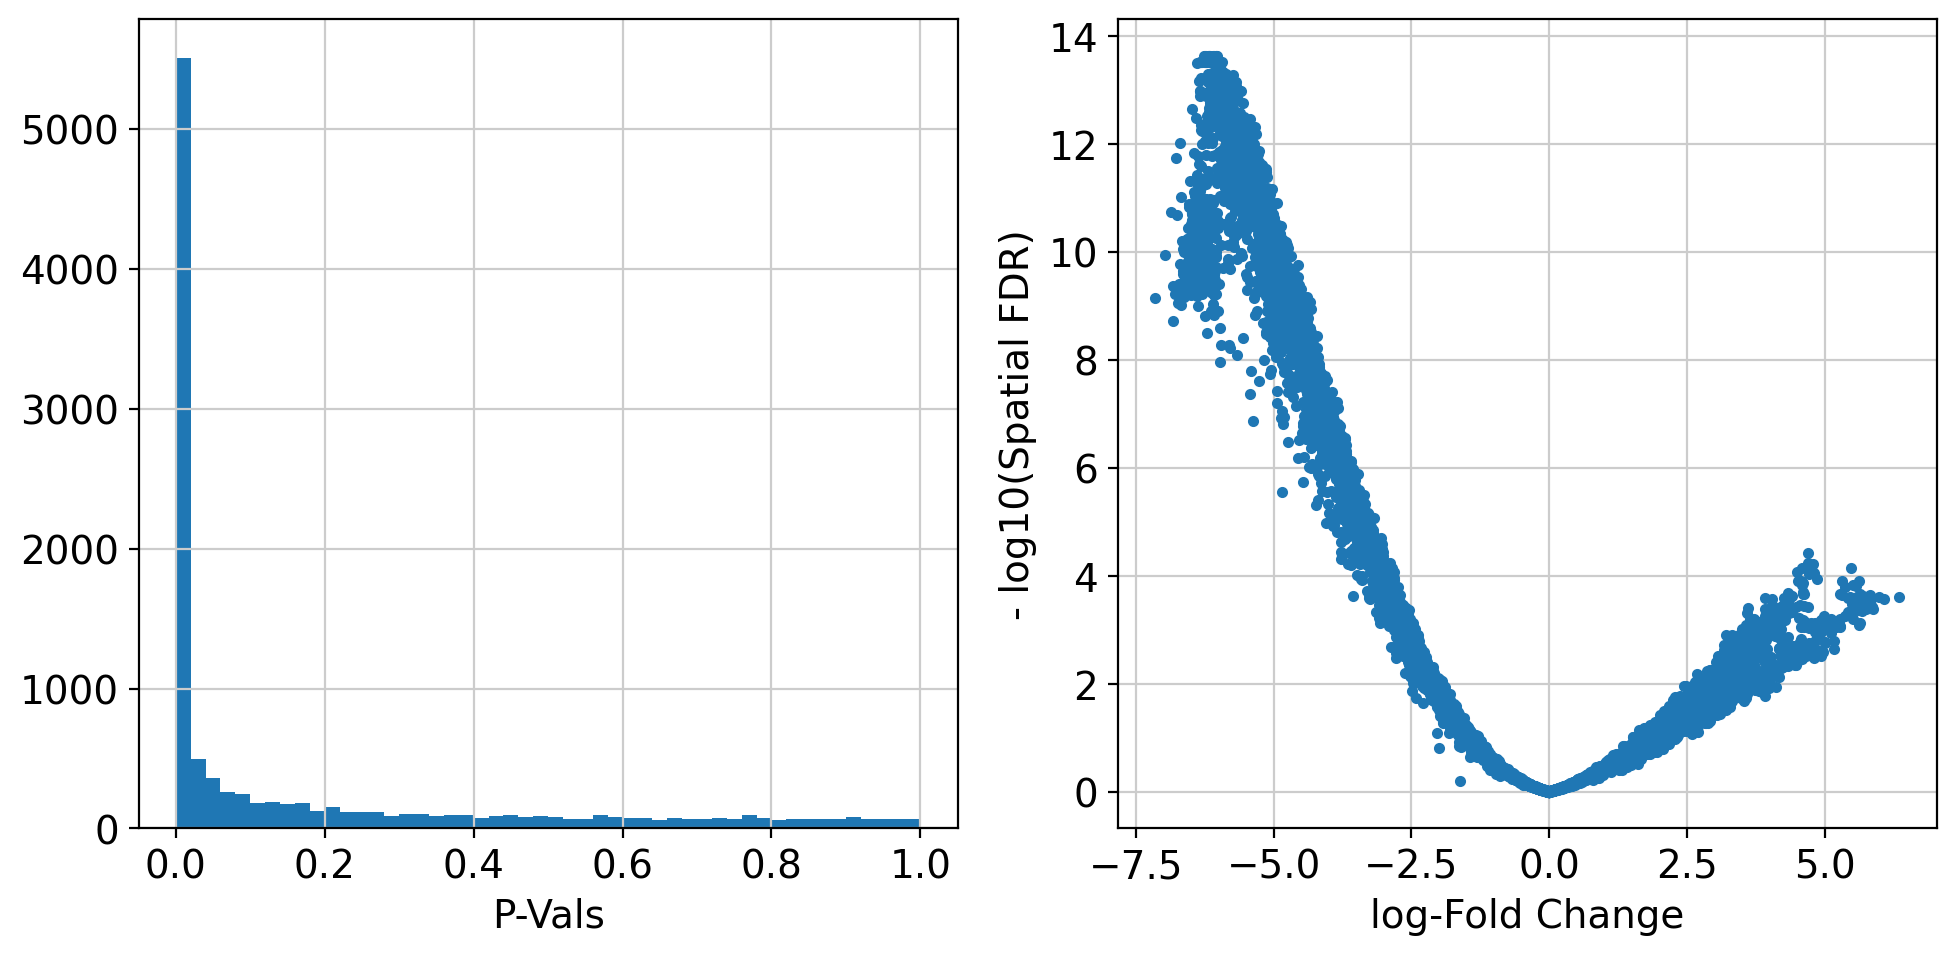

In [19]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [20]:
import milopy.utils
milopy.utils.build_nhood_graph(adata, basis = 'X_umap')

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


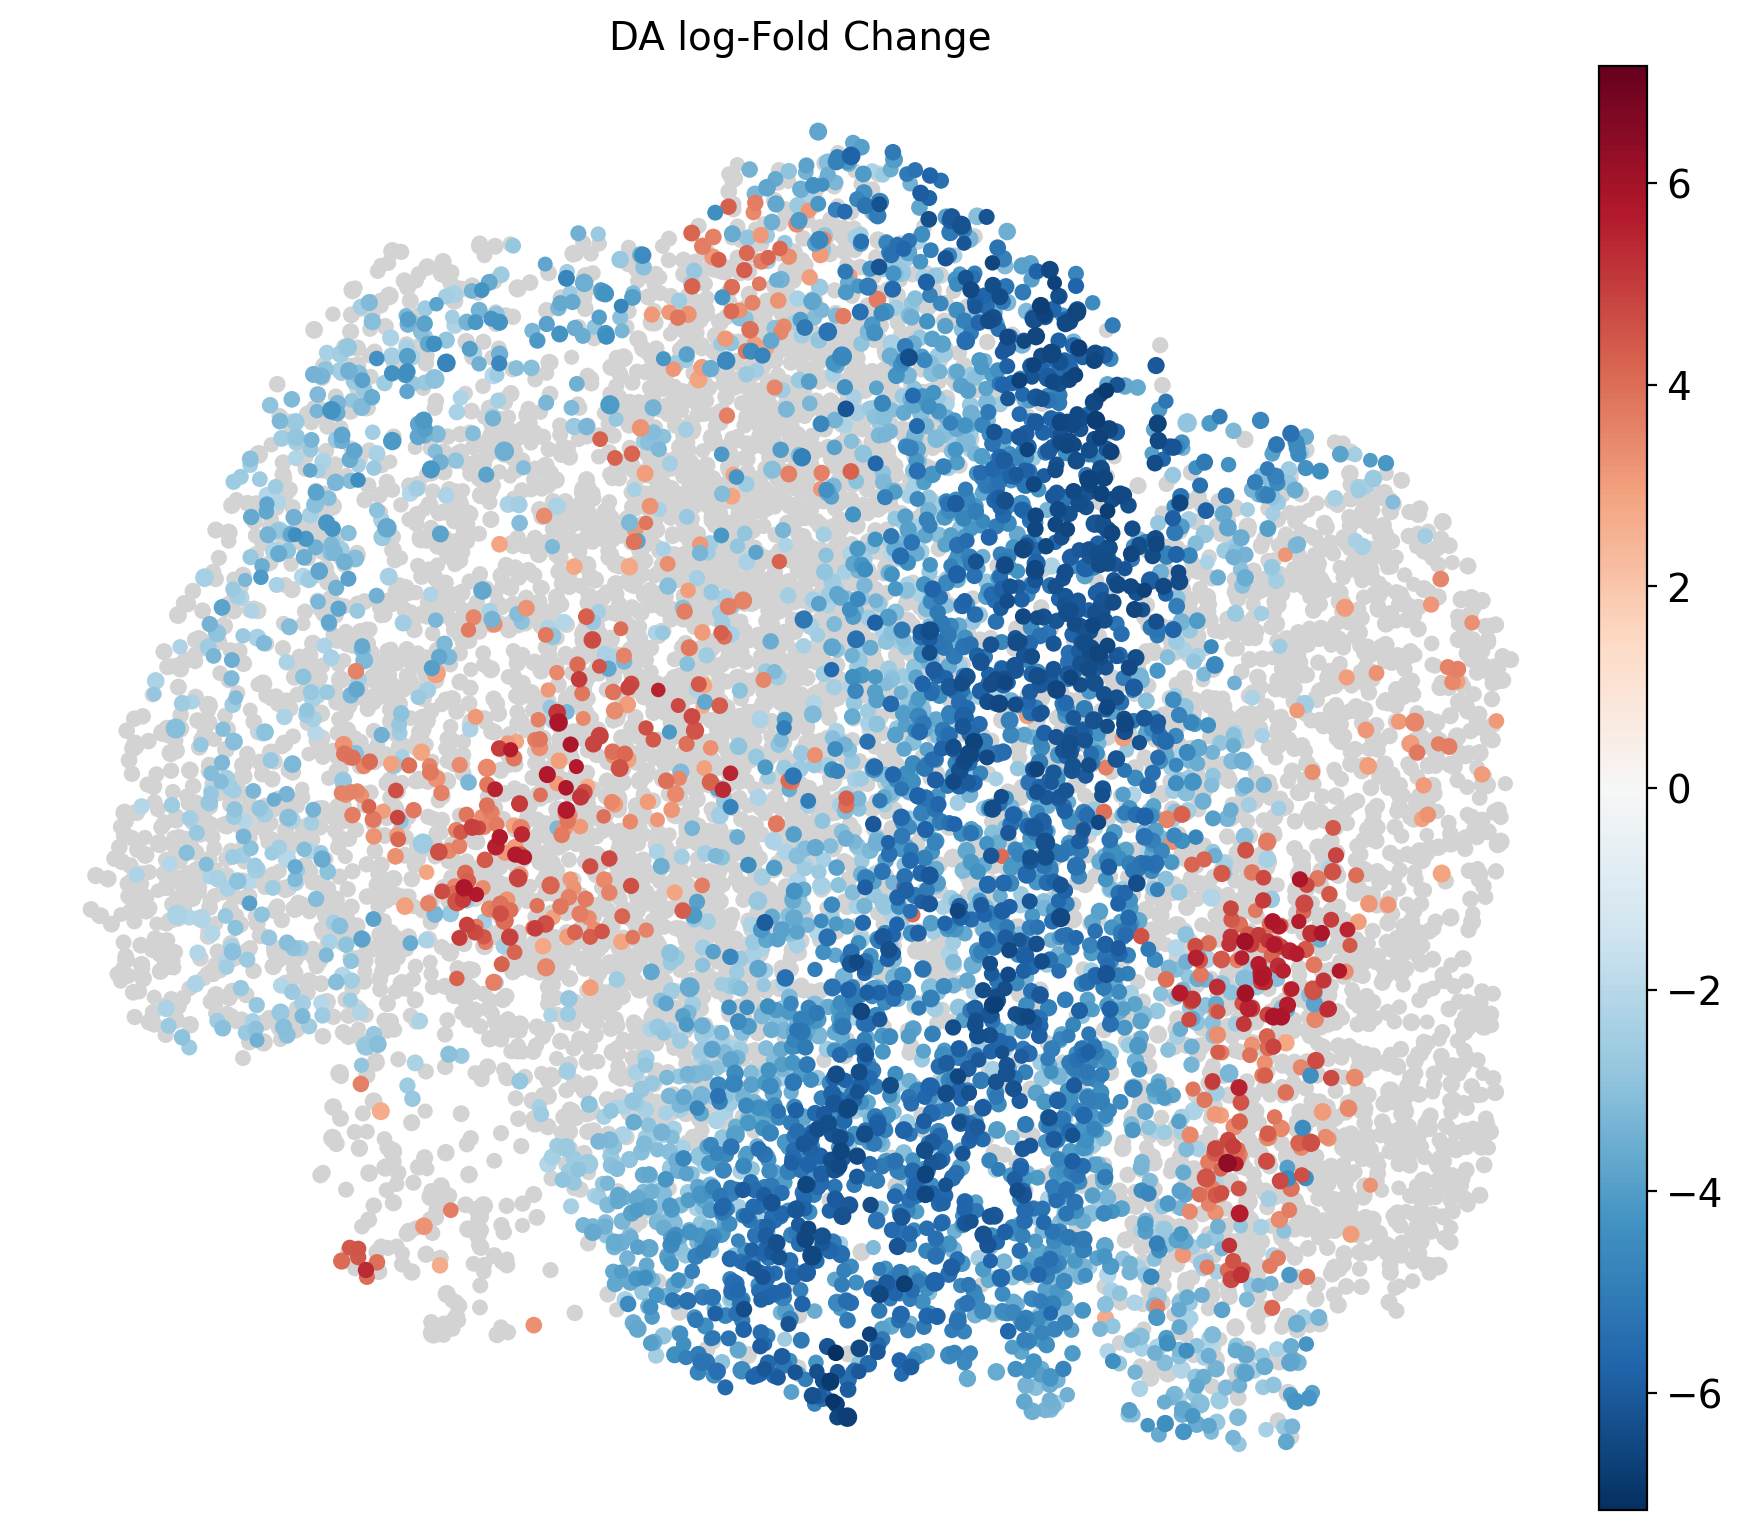

In [21]:
plt.rcParams["figure.figsize"] = [11,9.5]
milopl.plot_nhood_graph(adata, 
                        alpha=0.01, ## SpatialFDR level (1%) 
                        min_size=1, ## Size of smallest dot\
                        plot_edges = False)

In [22]:
milopy.utils.annotate_nhoods(adata, anno_col='cell_type')

Text(0.5, 0, 'celltype fraction')

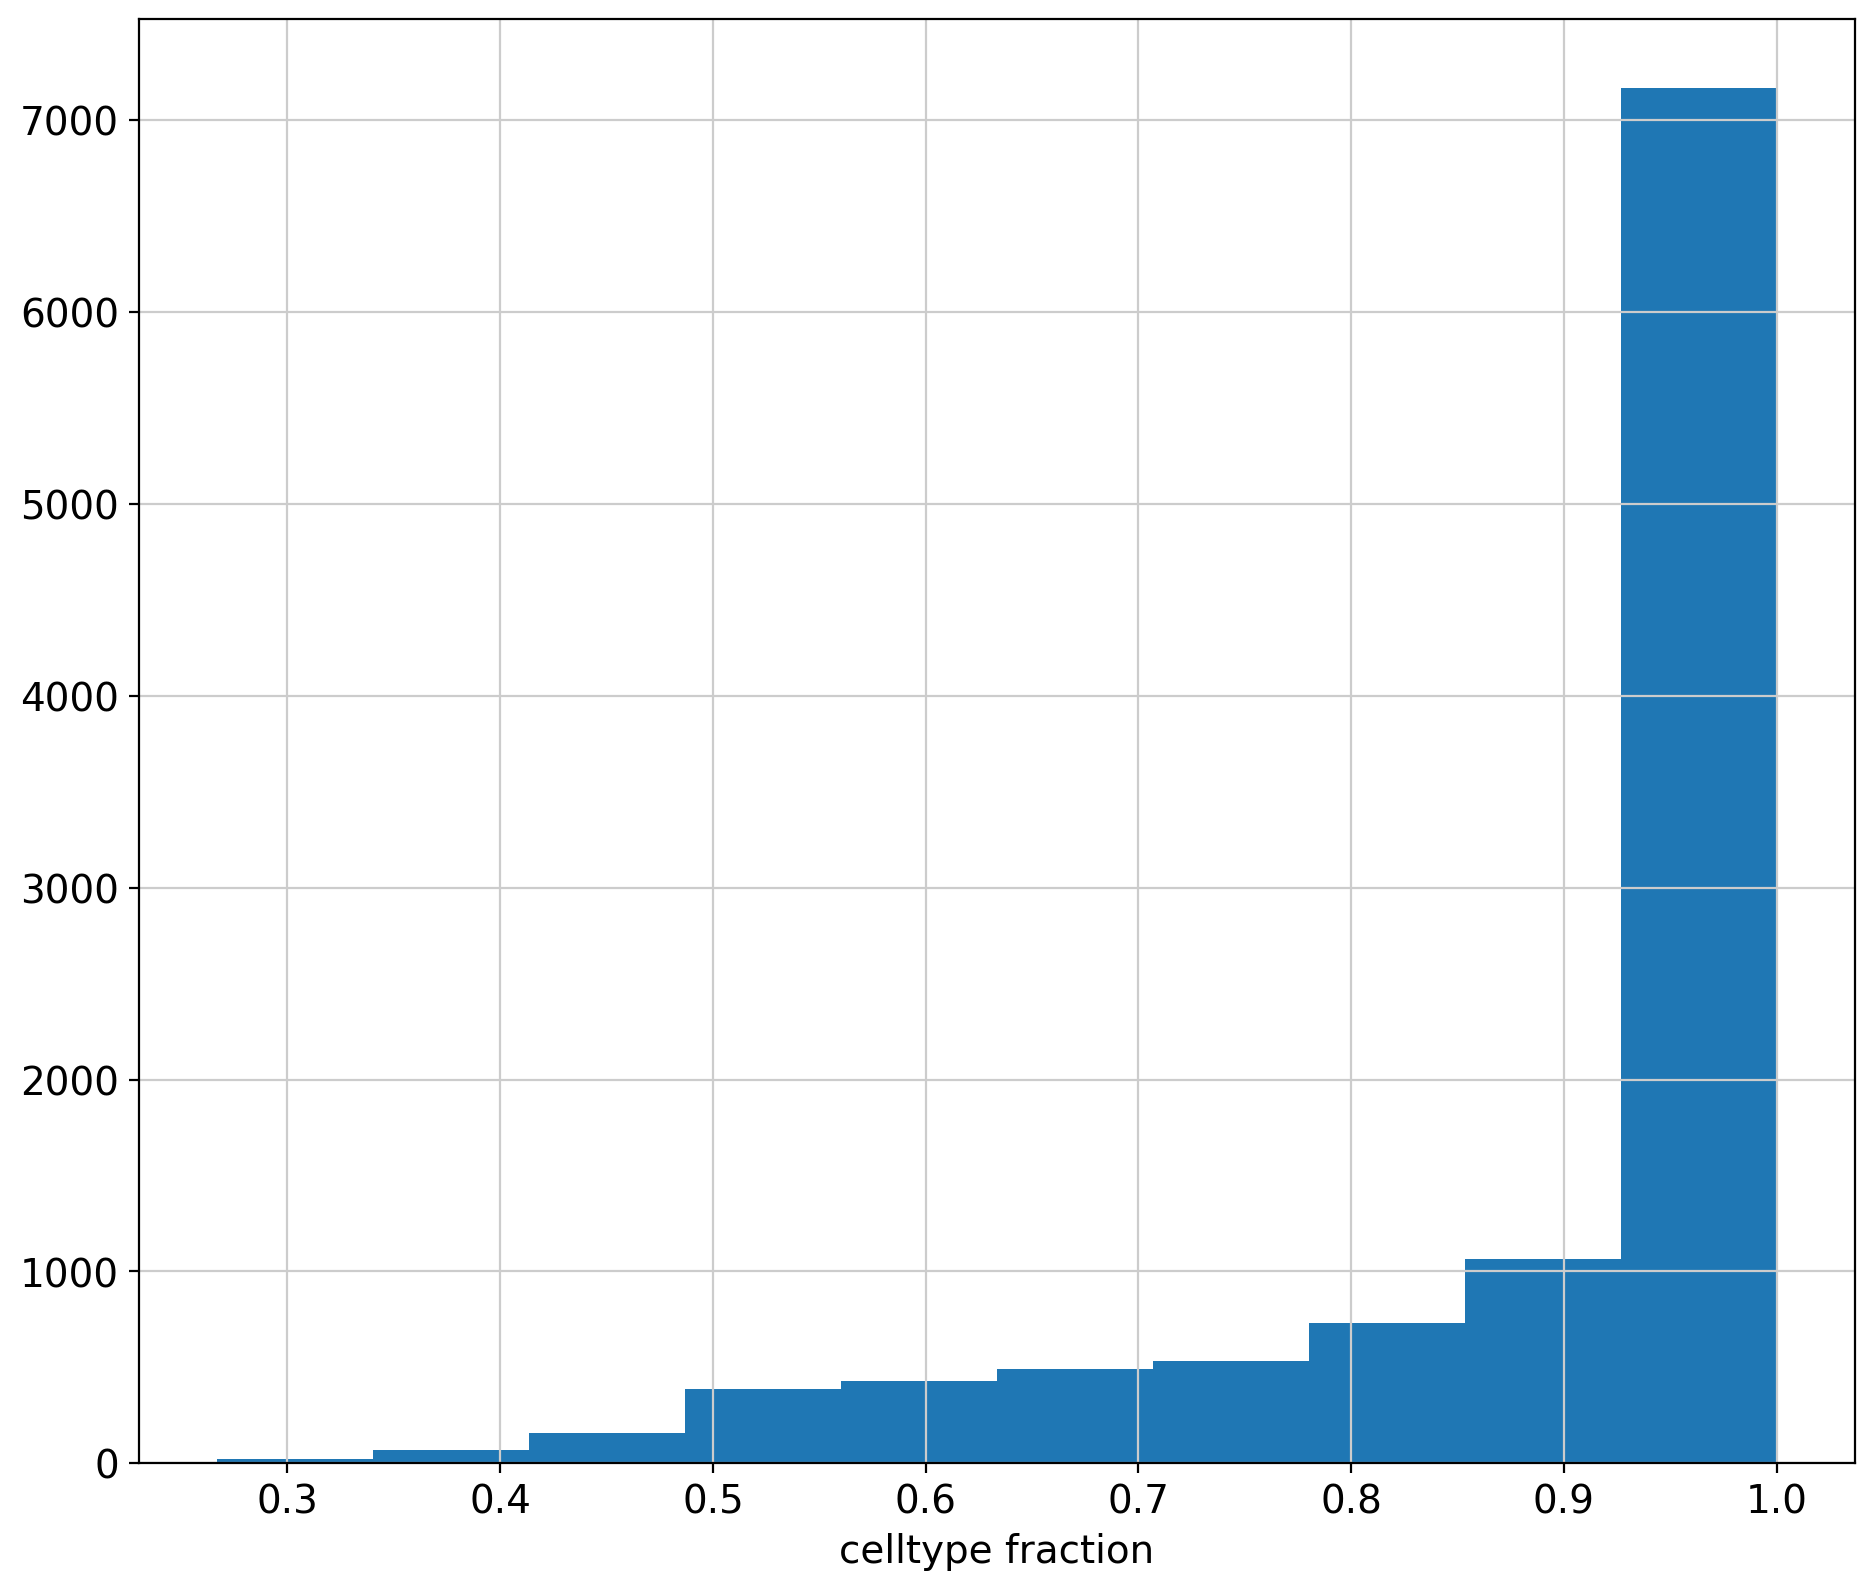

In [23]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [24]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.8, "nhood_annotation"] = "Mixed"

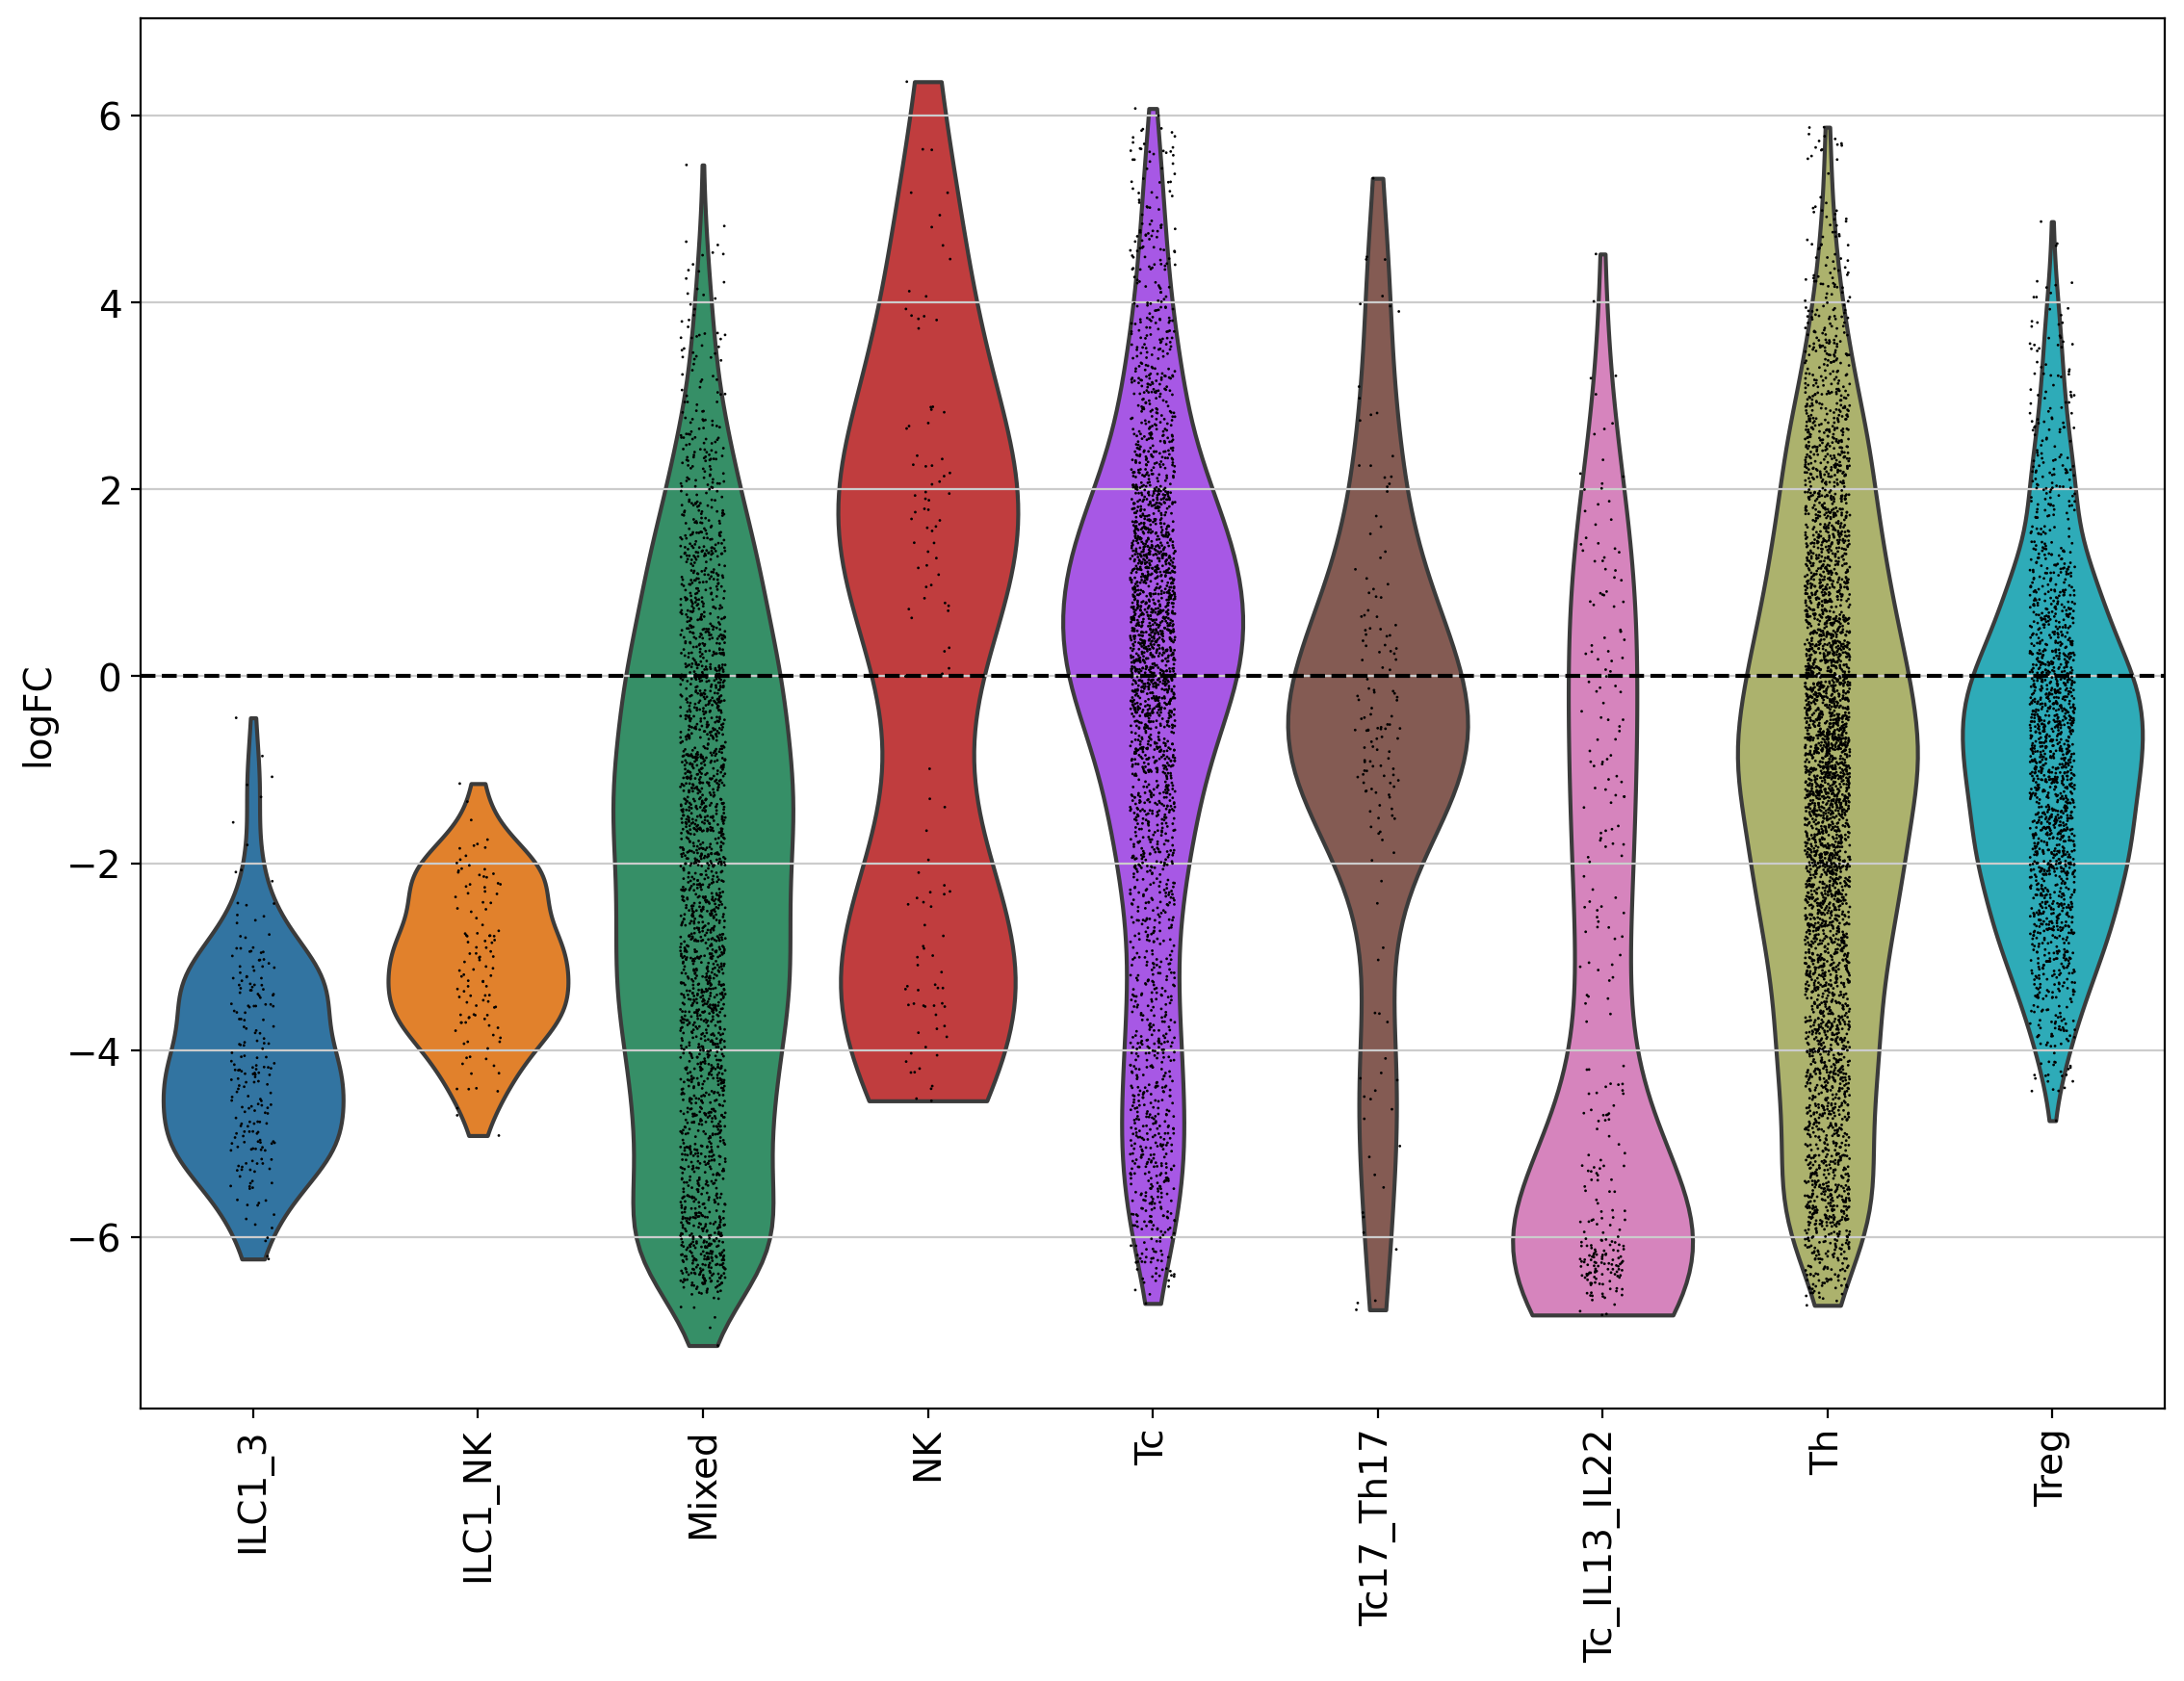

In [25]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

In [26]:
adata.uns["nhood_adata"].obs.to_csv('nhood_milo_BenignT.csv')

In [27]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [28]:
%load_ext rpy2.ipython

In [29]:
%%R
library(miloR)
library(igraph)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)

In [30]:
%%R 
DA_results <- read.csv('nhood_milo_BenignT.csv')
DA_results$Nhood <- DA_results$Nhood+1
DA_results %>% head

  X                           index_cell kth_distance      logFC   logCPM
1 0 GAACCTAGTCTCCACT-1_CTCL1_CTCL1_CTCL1    0.5459815 -0.5815634 8.220523
2 1 GACCAATGTTTCGCTC-1_CTCL1_CTCL1_CTCL1    0.4034983 -3.4833099 8.436118
3 2 GTCCTCAGTTCAGCGC-1_CTCL1_CTCL1_CTCL1    0.4749639  1.5323300 8.682499
4 3 GTGTTAGAGGGCTCTC-1_CTCL1_CTCL1_CTCL1    0.4259524 -2.8017679 8.337214
5 4 GTGTTAGTCCACTCCA-1_CTCL1_CTCL1_CTCL1    0.4240597 -0.7713005 8.375324
6 5 AAGTCTGCAGGGTATG-2_CTCL1_CTCL1_CTCL1    0.3048758 -0.9117653 8.121278
           F       PValue          FDR   SpatialFDR Nhood_size nhood_annotation
1  0.4707558 4.941453e-01 5.924594e-01 5.979697e-01        152        Tc17_Th17
2 27.5470732 7.987678e-07 3.684004e-06 3.883051e-06        132             Treg
3  3.1310260 7.970569e-02 1.328548e-01 1.365431e-01        159             Treg
4 14.6945127 2.152992e-04 6.815930e-04 7.133758e-04        130            Mixed
5  1.1201301 2.923085e-01 3.900200e-01 3.955613e-01        140             Treg
6 

In [31]:
%%R 
DA_results_filter <- DA_results[DA_results$SpatialFDR < 0.01,]
DA_results_filter %>% head

    X                           index_cell kth_distance     logFC   logCPM
2   1 GACCAATGTTTCGCTC-1_CTCL1_CTCL1_CTCL1    0.4034983 -3.483310 8.436118
4   3 GTGTTAGAGGGCTCTC-1_CTCL1_CTCL1_CTCL1    0.4259524 -2.801768 8.337214
7   6 ATCACGATCCTGCCAT-2_CTCL1_CTCL1_CTCL1    0.3634832 -2.124273 8.517123
13 12 GGAAAGCTCCGTCAAA-2_CTCL1_CTCL1_CTCL1    0.5207369  4.104804 8.762239
24 23 GCATGCGGTCCGAGTC-3_CTCL1_CTCL1_CTCL1    0.4848741  3.712435 8.517162
32 31 TGGCTGGGTTCCCGAG-3_CTCL1_CTCL1_CTCL1    0.4363340  3.549312 8.421061
           F       PValue          FDR   SpatialFDR Nhood_size nhood_annotation
2  27.547073 7.987678e-07 3.684004e-06 3.883051e-06        132             Treg
4  14.694513 2.152992e-04 6.815930e-04 7.133758e-04        130            Mixed
7   8.934911 3.481415e-03 8.560932e-03 8.905533e-03        163             Treg
13 14.630292 2.218310e-04 7.002986e-04 7.328737e-04        156               Tc
24 14.314717 2.570093e-04 8.019562e-04 8.392830e-04        139             

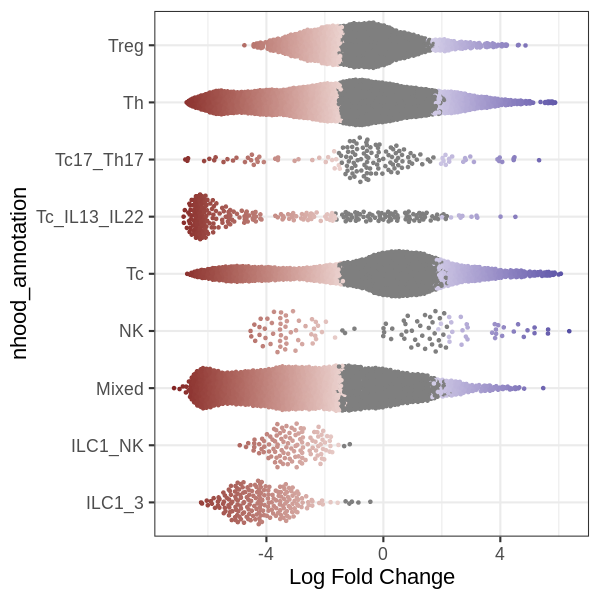

In [32]:
%%R -w 600 -h 600
plotDAbeeswarm(DA_results, group.by = "nhood_annotation")

In [34]:
%%R -w 800 -h 900 
library(ggplot2)

DA_results_filter <- DA_results[DA_results$nhood_annotation != 'Mixed', ]

plotDAbeeswarm(DA_results_filter, group.by = "nhood_annotation") + 
    theme(legend.position = "none") +
    #theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
    geom_hline(yintercept=0, linetype=2, color="black")+
    scale_colour_gradient2(low = scales::muted("blue"), mid = "white",
                           high = scales::muted("red"))

ggsave("./figures/milo_BenignT.pdf", width = 10.5, height = 12.5)
### "cell_states" represents pre-defined/pre-annotated cell clusters

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
